In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Load the data 
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
# Make a dataframe
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Print out the dataframe
# display(test_df)

# Show the test data 
# display(train_df)

# Set how many rows are set in the dataframe
pd.set_option('display.min_rows', 10) 
pd.set_option('display.max_rows', 10) 

display(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Import the methods for pipeline processing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Function to take a dataframe and prepare it for training. It imputes (fills missing values) for"Age" and "Fare", 
# makes the "Cabin" and "Sex" column binary (i.e in a cabin or not, male or female) and one hot encodes the "Embarked" column. 
def prepare_dataframe(df, drop_columns):
    # Copying dataframe to manipulate
    new_df = df.copy(deep=True)
    
    new_df["Cabin"] = new_df["Cabin"].notnull().astype('int')
    
    binary_mapping = {"male" : 0, "female": 1}
    new_df["Sex"] = new_df["Sex"].map(binary_mapping)
    
    numeric_features = ["Age", "Fare"]
    categorical_features = ["Embarked"]
    
    numeric_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy="mean"))])
    
    categorical_transformer = Pipeline(steps = [ ("imputer", SimpleImputer(strategy = "constant", 
                                                                           fill_value="missing")),
                                               ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_features),
                                                    ("cat", categorical_transformer, categorical_features)])
    
    preprocessor.fit(new_df)
    
    transformed_data = preprocessor.transform(new_df)
    
     
    numeric_data = transformed_data[:, :len(numeric_features)]
    categorical_data = transformed_data[:, len(numeric_features):]
    
    categorical_encoded_features = preprocessor.named_transformers_['cat']['onehot'] \
                                    .get_feature_names_out(input_features=categorical_features)
    
    # Replace the columns with transformed data
    new_df[categorical_encoded_features] = categorical_data 
    new_df[numeric_features] = numeric_data
    
    # Emabarked missing removed for the training set as it has a null value 
    if "Embarked_missing" in new_df.columns:
        new_df.drop("Embarked_missing", axis=1, inplace=True)
    
    new_df.drop(drop_columns,axis =1, inplace=True)
    
    return pd.DataFrame(new_df)

0
177
0
1


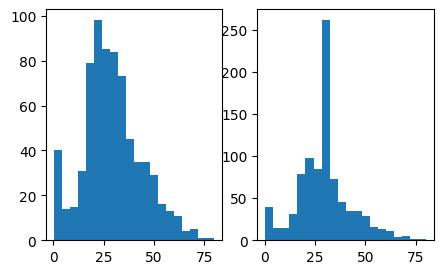

In [4]:
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

#Plotting histograms of the feature variables
fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize = (5,3))

#print(len(train_df["Age"]), len(train_df_missing["Age"]))

ax[0].hist(train_df["Age"], bins=20);

ax[1].hist(new_train_df["Age"], bins=20);

print(new_train_df["Age"].isna().sum())
print(train_df["Age"].isna().sum())

print(new_test_df["Fare"].isna().sum())
print(test_df["Fare"].isna().sum())

In [5]:
# Quick fitting of the data

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

# First RandomForestClassifier 

# Setup the random seed
np.random.seed(42)

# Split up into feature variables and target variables
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = new_test_df

# Import randomforestclassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

# display(x_train)
# display(x_test)
# display(new_test_df)

RandomForestClassifier()

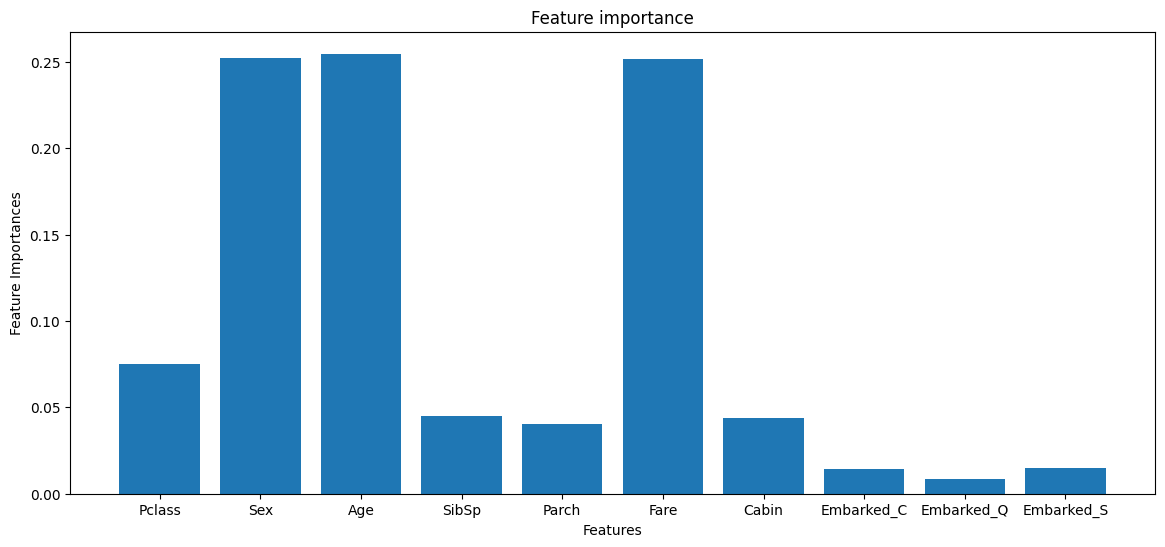

In [6]:
# Gives the importance of different features of the model
importance = clf.feature_importances_

importance_dictionary = {x_train.columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

plt.figure(figsize=(14, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

In [7]:
from sklearn.base import clone
np.random.seed(42)

drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]
drop_columns_cabin = ["Embarked", "Ticket", "Name", "PassengerId", "Cabin"]
drop_columns_embarked = ["Embarked","Embarked_C", "Embarked_S", "Embarked_Q", "Ticket", "Name", "PassengerId", "Cabin"]
drop_columns_age = ["Embarked","Embarked_C", "Embarked_S", "Embarked_Q", "Ticket", "Name", "PassengerId", "Cabin", "Age", "Sex"]

from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

grid = {
    'n_estimators': [10, 100, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt'],
    'bootstrap': [True, False]
}
 

# Setup the random seed
np.random.seed(42)

# Split up into feature variables and target variables
x_train = prepare_dataframe(train_df, drop_columns).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = prepare_dataframe(test_df, drop_columns)

x_train_cabin = prepare_dataframe(train_df, drop_columns_cabin).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_cabin = prepare_dataframe(test_df, drop_columns_cabin)

x_train_embarked = prepare_dataframe(train_df, drop_columns_embarked).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_embarked = prepare_dataframe(test_df, drop_columns_embarked)

x_train_age = prepare_dataframe(train_df, drop_columns_age).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_age = prepare_dataframe(test_df, drop_columns_age)


clf = RandomForestClassifier(n_jobs = 1)

rs_clf = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 20, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )


#display(x_train, x_train_cabin, x_train_embarked, x_train_age)
# print(cross_val_index(5, x_train,y_train, 1))

#rs_clf.fit(x_train, y_train);
#best_params = rs_clf.best_params_
#cv_results = rs_clf.cv_results_
#rs_clf.fit(x_train_cabin, y_train);
#best_params_cabin = rs_clf.best_params_
#cv_results_cabin = rs_clf.cv_results_
'''
rs_clf.fit(x_train_embarked, y_train);
best_params_embarked = rs_clf.best_params_
cv_results_embarked = rs_clf.cv_results_
'''
#rs_clf.fit(x_train_age, y_train);
#best_params_age = rs_clf.best_params_
#cv_results_age = rs_clf.cv_results_




'\nrs_clf.fit(x_train_embarked, y_train);\nbest_params_embarked = rs_clf.best_params_\ncv_results_embarked = rs_clf.cv_results_\n'

In [8]:
pd.set_option('display.min_rows', 20) 
pd.set_option('display.max_rows', 20) 
#print(best_params)
#display(pd.DataFrame(cv_results))

#print(best_params_cabin)
#display(pd.DataFrame(cv_results_cabin))
'''
print(best_params_embarked)
display(pd.DataFrame(cv_results_embarked))
'''
#print(best_params_age) 
#display(pd.DataFrame(cv_results_age))

'\nprint(best_params_embarked)\ndisplay(pd.DataFrame(cv_results_embarked))\n'

712 891
179 179
0.8715083798882681
0.8156424581005587


'\nclf2 = RandomForestClassifier(n_estimators=500)\nnew_train_df = prepare_dataframe(train_df, drop_columns_age)\nx_train = new_train_df.drop(["Survived"], axis=1)\ny_train = new_train_df["Survived"]\ncross_val_dataframes = cross_val_index(5, x_train, y_train, 3)\ndisplay(cross_val_dataframes[0])\nclf2.fit(cross_val_dataframes[0], cross_val_dataframes[1])\ny_valid_preds = clf2.predict(cross_val_dataframes[2])\nprint(accuracy_score(y_valid_preds, cross_val_dataframes[3]))\n'

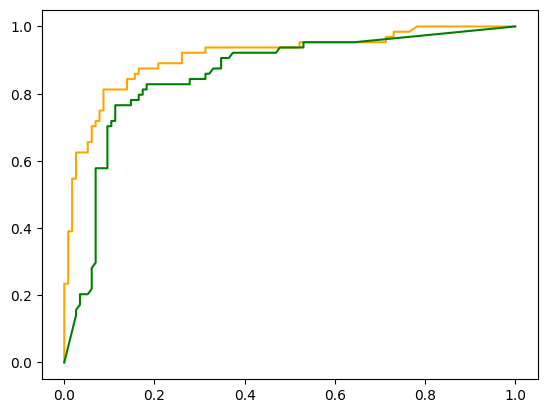

In [9]:
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve

np.random.seed(42)

# Function to divide a dataframe into validation and training sets with cross validation (k-folds). Returns the desired fold  
def cross_val_index(k_folds, x_dataframe, y_dataframe, fold_number):
    index = round(len(x_dataframe)/k_folds)
    start_index, end_index = [], []
    for i in range(k_folds):
                start_index.append(i * index)
                end_index.append((i + 1) * index if i < k_folds - 1 else len(x_dataframe))
    print(start_index[fold_number-1], end_index[fold_number-1])
    X_train = pd.concat([x_dataframe[:start_index[fold_number-1]], x_dataframe[end_index[fold_number-1]:]])
    y_train = pd.concat([y_dataframe[:start_index[fold_number-1]], y_dataframe[end_index[fold_number-1]:]])
    X_valid = x_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    y_valid = y_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    print(len(X_valid), len(y_valid))
    
    return X_train, y_train, X_valid, y_valid




drop_columns = ["Embarked", "Ticket", "Name", "PassengerId", "Cabin", "Embarked_C", "Embarked_S", "Embarked_Q"]
drop_columns_age = ["Embarked","Embarked_C", "Embarked_S", "Embarked_Q", "Ticket", "Name", "PassengerId", "Age", "Sex", "Pclass", "Fare", "SibSp", "Cabin"]
# drop_columns = ["Embarked","Embarked_C", "Embarked_S", "Embarked_Q", "Ticket", "Name", "PassengerId", "Cabin", "Parch"]

# Setting up validation dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]


cross_val_dataframes = cross_val_index(5, x_train, y_train, 5)


best_clf = RandomForestClassifier( **{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
best_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
best_y_valid_preds = best_clf.predict(cross_val_dataframes[2])
best_y_valids_proba = best_clf.predict_proba(cross_val_dataframes[2])
best_y_valids_proba_pos = best_y_valids_proba[:, 1]
print(accuracy_score(best_y_valid_preds, cross_val_dataframes[3]))

worst_clf = RandomForestClassifier( **{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
worst_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
worst_y_valid_preds = worst_clf.predict(cross_val_dataframes[2])
worst_y_valids_proba = worst_clf.predict_proba(cross_val_dataframes[2])
worst_y_valids_proba_pos = worst_y_valids_proba[:, 1]
print(accuracy_score(worst_y_valid_preds, cross_val_dataframes[3]))

best_fpr, best_tpr, best_thresholds = roc_curve(cross_val_dataframes[3].values, best_y_valids_proba_pos)
worst_fpr, worst_tpr, worst_thresholds = roc_curve(cross_val_dataframes[3].values, worst_y_valids_proba_pos)




plt.plot(best_fpr, best_tpr, color='orange', label='ROC')
plt.plot(worst_fpr, worst_tpr, color='green', label='ROC')

'''
clf2 = RandomForestClassifier(n_estimators=500)
new_train_df = prepare_dataframe(train_df, drop_columns_age)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
cross_val_dataframes = cross_val_index(5, x_train, y_train, 3)
display(cross_val_dataframes[0])
clf2.fit(cross_val_dataframes[0], cross_val_dataframes[1])
y_valid_preds = clf2.predict(cross_val_dataframes[2])
print(accuracy_score(y_valid_preds, cross_val_dataframes[3]))
'''

In [10]:
'''
print(rs_clf.best_params_)
display(pd.DataFrame(rs_clf.cv_results_))

print(rs_clf_embarked.best_params_)
display(pd.DataFrame(rs_clf_embarked.cv_results_))

print(rs_clf_cabin.best_params_)
display(pd.DataFrame(rs_clf_cabin.cv_results_))

print(rs_clf_age.best_params_)
display(pd.DataFrame(rs_clf_age.cv_results_))
'''

'\nprint(rs_clf.best_params_)\ndisplay(pd.DataFrame(rs_clf.cv_results_))\n\nprint(rs_clf_embarked.best_params_)\ndisplay(pd.DataFrame(rs_clf_embarked.cv_results_))\n\nprint(rs_clf_cabin.best_params_)\ndisplay(pd.DataFrame(rs_clf_cabin.cv_results_))\n\nprint(rs_clf_age.best_params_)\ndisplay(pd.DataFrame(rs_clf_age.cv_results_))\n'

In [11]:
'''print(rs_clf_embarked.best_params_)
display(pd.DataFrame(rs_clf_embarked.cv_results_))
'''

'print(rs_clf_embarked.best_params_)\ndisplay(pd.DataFrame(rs_clf_embarked.cv_results_))\n'

In [12]:
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId", "Cabin", "Embarked_C", "Embarked_S", "Embarked_Q"]

new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = prepare_dataframe(test_df, drop_columns)

best_clf = RandomForestClassifier( **{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
best_clf.fit(x_train, y_train)
best_y_preds = best_clf.predict(x_test)


output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': best_y_preds})
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
..           ...       ...
408         1300         1
409         1301         1
410         1302         1
411         1303         1
412         1304         1
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
Your submission was successfully saved!
